In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import datetime
#from torch.utils.tensorboard import SummaryWriter

W1213 10:10:05.701276  7752 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1213 10:10:05.733263  7752 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
np.random.seed(1)
torch.manual_seed(1)
torch.set_num_threads(4)

batch_size = 8
learning_rate = 0.1
percentagePoisonedData = 1.0
NO_BENIGN = 10
NO_FRAUDS = 0
modelReplacement = False

# Creating workers

In [3]:
def createClients(num_training, num_frauds):
    remote_dataset = tuple([list() for x in range((num_training + num_frauds))])
    models = []
    params = []
    optimizers = []
    compute_nodes = []
    frauds = []
    for i in range(num_training+num_frauds):
        m = Net().to(device)
        models.append(m)
        params.append(list(m.parameters()))
        optimizers.append(optim.SGD(m.parameters(), lr=learning_rate))
        
    for i in range(num_training):
        compute_nodes.append(sy.VirtualWorker(hook, id=("benign_" + str(i))))
    
    for i in range(num_frauds):
        frauds.append(sy.VirtualWorker(hook, id=("fraud_" + str(i))))
        
    return remote_dataset, models, params, optimizers, compute_nodes, frauds

# Helper function for dataset loader generation

In [4]:
#def generateLoadersPerClass(dataset):
#    #loaders per class
#    loaders_per_class = []
#    for class_name in dataset.classes:
#        # get the indices in the dataset that are relative to that class
#        idx = [
#            pos for pos, item in enumerate(dataset.samples)
#            if item[1] == dataset.class_to_idx[class_name]]
#        # construct the corresponding dataloader thanks to a SubsetRandomSampler
#        loaders_per_class += [torch.utils.data.DataLoader(
#            dataset, 
#            batch_size=batch_size,
#            sampler=SubsetRandomSampler(idx),
#            **kwargs)]
#    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original',
                             transform=data_transform)
original_loader = torch.utils.data.DataLoader(trafficsign, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original_test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)


# Load backdoor dataset

In [6]:
#malicious data
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare',
                             transform=data_transform)
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loader = torch.utils.data.DataLoader(backdoored, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#backdoored_loaders = generateLoadersPerClass(backdoored)

#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare_test',
                             transform=data_transform)
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples] #set each image of backdoors to 001

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

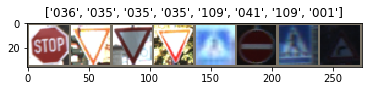

In [7]:
class_names = trafficsign.classes

#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(original_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf


# Secure Multiparty computation: send datasets to clients

In [ ]:
def distributeDataToClients(num_training, num_frauds, percentagePoisonedData):
    global remote_dataset
    total_number_of_clients = num_training + num_frauds
    total_batches = 0
    #add original data
    for i, (d,t) in enumerate(original_loader): # run multiple times over the dataset to increase its size
        data = d.to(device)
        target = t.to(device)
        if(percentagePoisonedData == 1.0): #do not add original data to backdoor clients
            data = data.send(compute_nodes[i % num_training])
            target = target.send(compute_nodes[i % num_training])
            remote_dataset[i % num_training].append((data, target))
        else: #also add original data to backdoor clients (and remove after)
            targetClient = i % total_number_of_clients
            if (targetClient < num_training): #add to benign clients
                data = data.send(compute_nodes[targetClient])
                target = target.send(compute_nodes[targetClient])
            else: #add to malicious clients
                data = data.send(frauds[targetClient-num_training])
                target = target.send(frauds[targetClient-num_training])
            remote_dataset[targetClient].append((data, target))
        total_batches += 1
    

    if (num_frauds != 0):
    #add backdoor data
        all_backdoored_data = []
        for i, (d,t) in enumerate(original_loader):
            data = d.to(device)
            target = t.to(device)
            data = data.send(frauds[(i+1) % len(frauds)])
            target = target.send(frauds[(i+1) % len(frauds)])
            all_backdoored_data.append((data, target))
        
        
        #get subset of data to match with the number of benign and malicious nodes (100% backdoor, 0% benign data)
        total_data = total_batches * (len(compute_nodes) + len(frauds))/len(compute_nodes)
        fraction_of_backdoored_clients = len(frauds)/(len(compute_nodes) + len(frauds))
        shuffle(all_backdoored_data)
        all_backdoored_data = all_backdoored_data[:int(total_data*fraction_of_backdoored_clients)]
        
        
        #shorten benign data
        for i in range(num_frauds): 
            shuffle(remote_dataset[num_training+i])
            temp = list(remote_dataset)
            temp[num_training+i] = temp[num_training+i][:int((1-percentagePoisonedData) * len(temp[0]))]
            remote_dataset = tuple(temp)
            
        length = int((percentagePoisonedData) * len(temp[0]))
        #add each backdoor to remote_dataset
        for d,t in all_backdoored_data:
            if (length > 0): #only add percentage of backdoor data
                for i in range(num_frauds): #for each malicious client
                    remote_dataset[num_training + i].append((d, t)) # append new backdoored batch
            length -=1

In [ ]:
hook = sy.TorchHook(torch)

remote_dataset, models, params, optimizers, compute_nodes, frauds = createClients(NO_BENIGN,NO_FRAUDS)
distributeDataToClients(NO_BENIGN,NO_FRAUDS,percentagePoisonedData)

def update(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    pred = model(data)
    loss = F.cross_entropy(pred, target)
    losscopy = loss.copy().get()
    loss.backward()
    optimizer.step()
    return losscopy, model

#model replacement attack (see https://arxiv.org/pdf/1807.00459.pdf)
def update_poison(data, target, model, optimizer):
    global_model = model
    updated_Model = update(data, target, model, optimizer)
    
    clip_rate = (len(compute_nodes) + len(frauds)) #number_of_participants
    print(f"Scaling by  {clip_rate}")
    
    for key, value in updated_Model.state_dict().items():
        target_value = global_model.state_dict()[key]
        new_value = target_value + (value - target_value) * clip_rate
        updated_Model.state_dict()[key].copy_(new_value)
        
    return updated_Model

# Training Function

In [ ]:
def trainSMPC(epoch, modelReplacement):
    minimumOfBatchesOverAllClients = min(map(len, remote_dataset))
    total_number_of_clients = int(len(compute_nodes) + len(frauds))
    total_mean_loss = 0
    total_mean_loss_backdoor = 0
    for data_index in range(minimumOfBatchesOverAllClients): #iterates over batches
        mean_loss = 0
        mean_loss_backdoor = 0
        print(f"update remote models {data_index+1} / {minimumOfBatchesOverAllClients}")
        for remote_index in range(total_number_of_clients): #each client of a batch
            d, t = remote_dataset[remote_index][data_index]
            data = d.to(device)
            target = t.to(device)
            
            if(modelReplacement == True):
                if (remote_index > len(compute_nodes)):
                    losscopy_backdoor, model = update_poison(data, target, models[remote_index], optimizers[remote_index])
                    models[remote_index] = model
                    mean_loss_backdoor = losscopy_backdoor
                else:
                    losscopy, model = update(data, target, models[remote_index], optimizers[remote_index])
                    models[remote_index] = model
                    mean_loss += losscopy
            else:
                losscopy, model = update(data, target, models[remote_index], optimizers[remote_index])
                models[remote_index] = model
                mean_loss += losscopy
        
        new_params = list()
        for param_i in range(len(params[0])):
            spdz_params = list()
            for remote_index in range(total_number_of_clients):
                copy_of_parameter = (params[remote_index][param_i]).get()
                spdz_params.append(copy_of_parameter)
            
            new_param = sum(spdz_params)/total_number_of_clients
            new_params.append(new_param)
        
        with torch.no_grad():
            for m in params:
                for param in m:
                    param *= 0

            for remote_index in range(total_number_of_clients):
                for param_index in range(len(params[remote_index])):
                    params[remote_index][param_index].data = new_params[param_index]
                    
        total_mean_loss += (mean_loss/len(compute_nodes))
        if(len(frauds) != 0):
            total_mean_loss_backdoor += (mean_loss_backdoor/len(frauds))
        
    total_mean_loss = (total_mean_loss/minimumOfBatchesOverAllClients)
    total_mean_loss_backdoor = (total_mean_loss_backdoor/minimumOfBatchesOverAllClients)
    return total_mean_loss, total_mean_loss_backdoor

In [ ]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            d, t = data.to(device), target.to(device)
            output = model(d)
            test_loss += F.cross_entropy(output, t, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [ ]:
#load old model
for model in models:
    model.load_state_dict(torch.load("exp_traffic_20191210-160723_epoch_15.pt"))

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_traffic_"+dateString+".txt"),"w+")

#EXP-setup
csv_header =  "#dataset: " + "trafficsign" + "\n"
csv_header += "#way backdoor looks like: " + "green_squares" + "\n"
csv_header += "#merge strategy: " + "aggregation" + "\n"
csv_header += "#learning rate: " + str(learning_rate) + "\n"
csv_header += "#number of benign sources: " + str(len(compute_nodes)) + "\n"
csv_header += "#number of malicious sources: " + str(len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(percentagePoisonedData) + "\n" #str(100)
csv_header += "#order of time backdoors being inserted: " + "no" + "\n" #backdoors first
csv_header += "#attack model: " + "basic" + "\n" #basic
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(16,101):
    print(f"Epoch {epoch}")
    
    csv_normal = "normal;" + str(epoch) + ";" + str(0.01) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(0.01) + ";"

    #train both - set order in method
    avg_training_loss, avg_training_backdoor_loss = trainSMPC(epoch, modelReplacement)
    csv_normal += str(avg_training_loss) + ";"
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_combined = datetime.datetime.now().strftime("%H%M%S")
    
    #save after each 10 iterations
    if epoch % 5 == 0:
        torch.save(models[0].state_dict(), ("exp_traffic_"+dateString +"_epoch_" + str(epoch) + ".pt"))
    
    #test backdoor
    test_loss, acc = test(models[0], device, dataset_loader_backdoored_test, len(testdata))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(models[0], device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"
    
    #timestamps
    csv_normal += timestamp_combined + "\n"
    csv_backdoor += timestamp_combined + "\n"
    
    #Write to file
    f= open(("exp_traffic_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()


#dataset: trafficsign
#way backdoor looks like: green_squares
#merge strategy: aggregation
#learning rate: 0.1
#number of benign sources: 10
#number of malicious sources: 0
#batch size: 8
#distribution of data: equally distributed subset
#percentage of poisoned data in backdoored nodes: 1.0
#order of time backdoors being inserted: no
#attack model: basic
#starttime: 101110
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Epoch 16
update remote models 1 / 123
update remote models 2 / 123
update remote models 3 / 123
update remote models 4 / 123
update remote models 5 / 123
update remote models 6 / 123
update remote models 7 / 123
update remote models 8 / 123
update remote models 9 / 123
update remote models 10 / 123
update remote models 11 / 123
update remote models 12 / 123
update remote models 13 / 123
update remote models 14 / 123
update remote models 15 / 123
update remote models 16 / 123
update remote models 17 / 123
update remote model

update remote models 73 / 123
update remote models 74 / 123
update remote models 75 / 123
update remote models 76 / 123
update remote models 77 / 123
update remote models 78 / 123
update remote models 79 / 123
update remote models 80 / 123
update remote models 81 / 123
update remote models 82 / 123
update remote models 83 / 123
update remote models 84 / 123
update remote models 85 / 123
update remote models 86 / 123
update remote models 87 / 123
update remote models 88 / 123
update remote models 89 / 123
update remote models 90 / 123
update remote models 91 / 123
update remote models 92 / 123
update remote models 93 / 123
update remote models 94 / 123
update remote models 95 / 123
update remote models 96 / 123
update remote models 97 / 123
update remote models 98 / 123
update remote models 99 / 123
update remote models 100 / 123
update remote models 101 / 123
update remote models 102 / 123
update remote models 103 / 123
update remote models 104 / 123
update remote models 105 / 123
upda

        [   0.,    0.,  649.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Epoch 19
update remote models 1 / 123
update remote models 2 / 123
update remote models 3 / 123
update remote models 4 / 123
update remote models 5 / 123
update remote models 6 / 123
update remote models 7 / 123
update remote models 8 / 123
update remote models 9 / 123
update remote models 10 / 123
update remote models 11 / 123
update remote models 12 / 123
update remote models 13 / 123
update remote models 14 / 123
update remote models 15 / 123
update remote models 16 / 123
update remote models 17 / 123
update remote models 18 / 123
update remote models 19 / 123
update remote models 20 / 123
update remote models 21 / 123
update remote models 22 / 123
update remote models 23 / 123
update remote models 24 / 123
update remote models 25 / 123
update remote models 26 / 123
update remote models 27 / 123
update remote models 28 / 123
update remote models 29 / 123


update remote models 85 / 123
update remote models 86 / 123
update remote models 87 / 123
update remote models 88 / 123
update remote models 89 / 123
update remote models 90 / 123
update remote models 91 / 123
update remote models 92 / 123
update remote models 93 / 123
update remote models 94 / 123
update remote models 95 / 123
update remote models 96 / 123
update remote models 97 / 123
update remote models 98 / 123
update remote models 99 / 123
update remote models 100 / 123
update remote models 101 / 123
update remote models 102 / 123
update remote models 103 / 123
update remote models 104 / 123
update remote models 105 / 123
update remote models 106 / 123
update remote models 107 / 123
update remote models 108 / 123
update remote models 109 / 123
update remote models 110 / 123
update remote models 111 / 123
update remote models 112 / 123
update remote models 113 / 123
update remote models 114 / 123
update remote models 115 / 123
update remote models 116 / 123
update remote models 11

        [   0.,    0.,  649.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Epoch 22
update remote models 1 / 123
update remote models 2 / 123
update remote models 3 / 123
update remote models 4 / 123
update remote models 5 / 123
update remote models 6 / 123
update remote models 7 / 123
update remote models 8 / 123
update remote models 9 / 123
update remote models 10 / 123
update remote models 11 / 123
update remote models 12 / 123
update remote models 13 / 123
update remote models 14 / 123
update remote models 15 / 123
update remote models 16 / 123
update remote models 17 / 123
update remote models 18 / 123
update remote models 19 / 123
update remote models 20 / 123
update remote models 21 / 123
update remote models 22 / 123
update remote models 23 / 123
update remote models 24 / 123
update remote models 25 / 123
update remote models 26 / 123
update remote models 27 / 123
update remote models 28 / 123
update remote models 29 / 123


In [ ]:
test(models[0], device, test_loader, len(testdata))